In [1]:
# LIB UPLOAD CELL:
###########################################


import MAIN_MODULE as mm

path_main = '/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/qRC/'
path_EVAL = path_main + 'EVALUATION/BRIDGEON_STM_60_1/'
path_EVAL_AUX = path_main + 'EVALUATION/BRIDGEON_STM_60/'
path_PRODUCT =  path_EVAL + 'PRODUCTION/'
mm.sys.path.append(path_main)

from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager 
from matplotlib.pyplot import gca



In [2]:
path_EVAL

'/Users/stepanvinckevich/Desktop/IMPORTANT NOW/QIS QRL/CODE/qRC/EVALUATION/BRIDGEON_STM_60_1/'

In [3]:
# EVALUATION CELL:
###########################################
num_signal_samples = 10
num_states_samples = 10
multiplexing = 10
# FUNCTION EVALUATE IMPLEMENT ANALYSIS WITH  BRIDGE SET TO ON !!!
def evaluate_bridge_on(init_state, signal, depolarization_prob):
    # Initialization
    inp = signal[2000:2200]
    result = mm.np.zeros((len(inp), multiplexing, mm.n_qubitsB))
    state = init_state
    # PRECPROCESSING --> IT IS NECESSARY TO SATISFY ECHO STATE PROPERTY. 2000 temporal preproc. steps.
    for i in range(2000):
        state = mm.encoding_step(state, signal[i])
        state = mm.evolution_step(state)
        state = mm.entangled_channel_AUX(state, depolarization_prob) ## ENTANGLING CHANNEL EXEC FUNCTION
    # READOUT  ( TEMPORAL MULTIPLEXING )
    for n in range(len(inp)):
        state = mm.encoding_step(state, inp[n])
        for m in range(multiplexing):
            state = mm.evolution_step(state)
            state = mm.entangled_channel_AUX(state, depolarization_prob)

            for site in range(mm.n_qubitsB):
                state, outcome = mm.separated_measurement_step(state, site + mm.n_qubitsA)
                result[n, m, site] = outcome

    return result

In [4]:
#EXECUTION CELL:
##########################################

for s in range(num_signal_samples):
    print('Signal sample num:' +  str(s))
    signal = [mm.np.random.choice(2) for _ in range(2200)]
    #signal = mm.np.load(path_main + '/data/complex_signal_9_9.npy')
    for i in mm.tqdm(range(num_states_samples)):
        # Initial density matrix
        init_state = mm.qt.tensor(*[mm.qt.rand_ket(2) for _ in range(mm.n_qubits_total)])
        init_state = init_state * init_state.dag()
        init_state = init_state.full()
        results = evaluate_bridge_on(init_state, signal, 0)
        mm.np.save(path_EVAL + str(s) + 'results' + str(i), results)
        mm.np.save(path_EVAL + str(s)+'signal', signal)

Signal sample num:0



Signal sample num:1



Signal sample num:2



Signal sample num:3



Signal sample num:4



Signal sample num:5



Signal sample num:6



Signal sample num:7



Signal sample num:8



Signal sample num:9


In [5]:
counter = 0
for s in range(num_signal_samples):
    res = []
    for i  in range(num_states_samples):
        res.append(mm.np.load(path_EVAL + str(s) + 'results' + str(i) + '.npy'))
    res_arr = mm.np.asarray(res)
    res_av = mm.np.mean(res_arr, axis = 0)

    k = mm.np.random.choice(num_states_samples)
    if mm.np.linalg.norm(res_av.reshape(-1, mm.n_qubitsB)[:, 0] - res[k].reshape(-1, mm.n_qubitsB)[:, 0]) >= 10**-6:
        counter += 1
if counter == 0:
    print ('ECHO STATE PROPERTY IS ELIGABLE')
else:
    print ('ECHO STATE PROPERTY FAILED')

ECHO STATE PROPERTY IS ELIGABLE


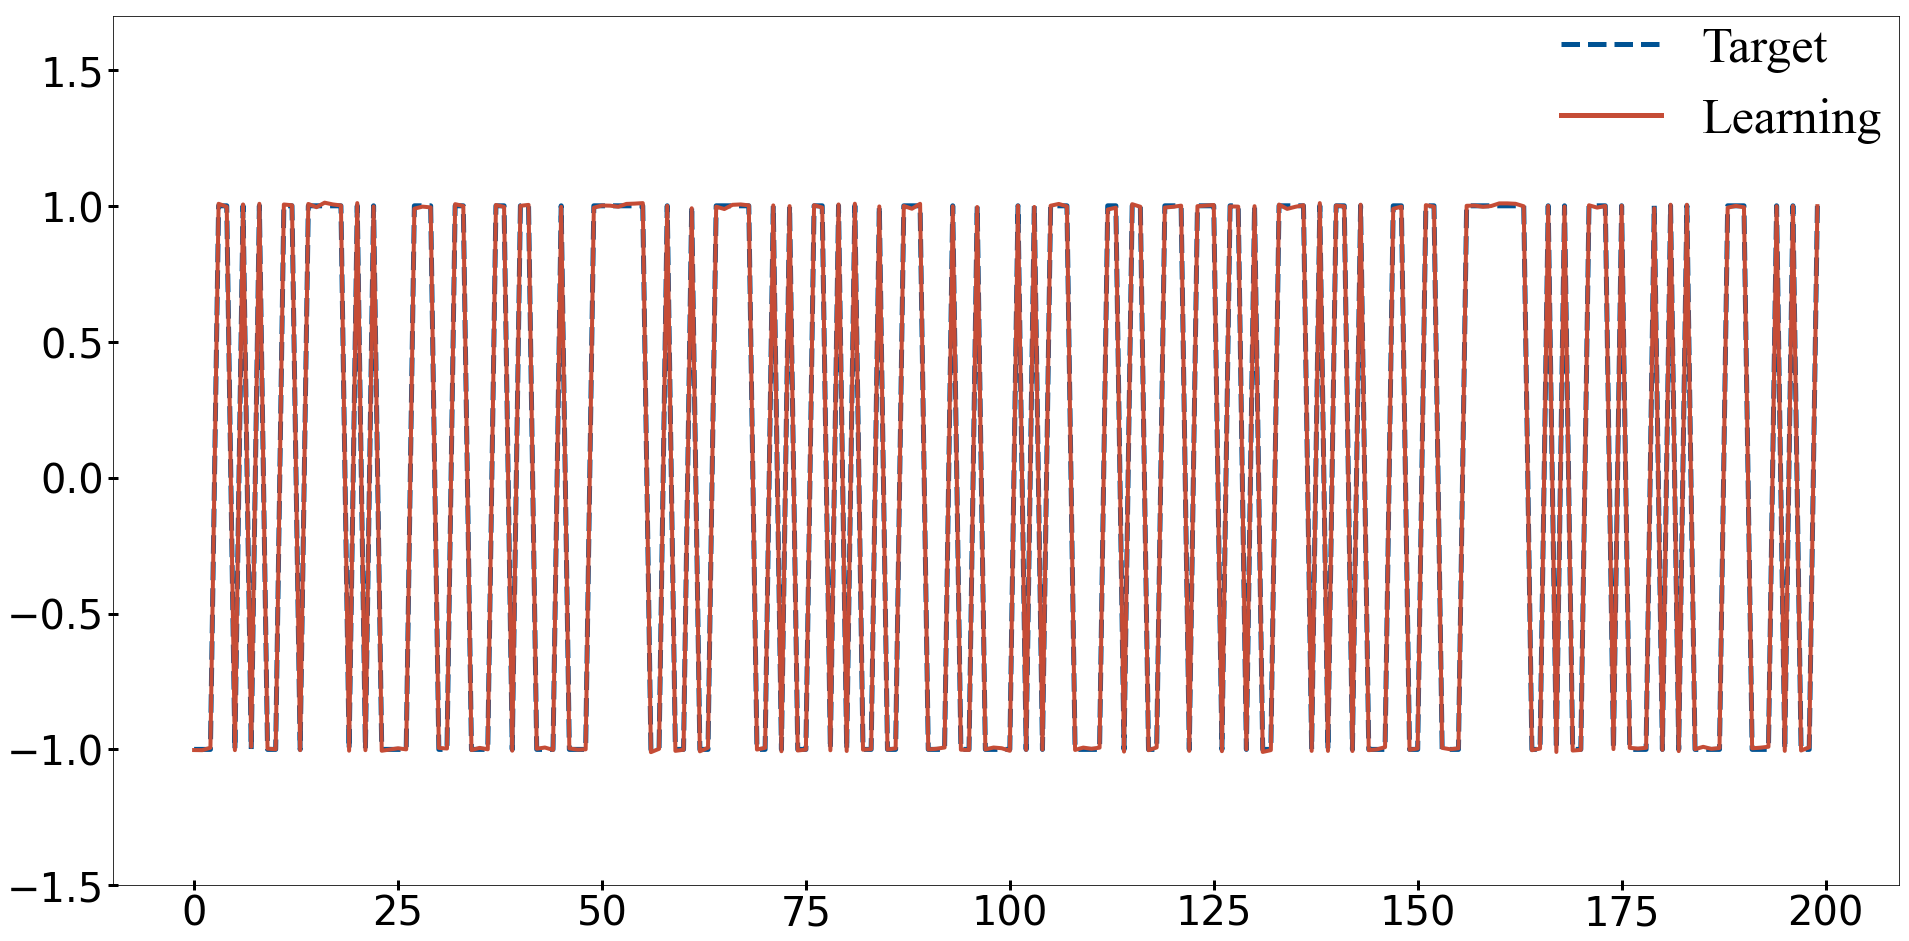

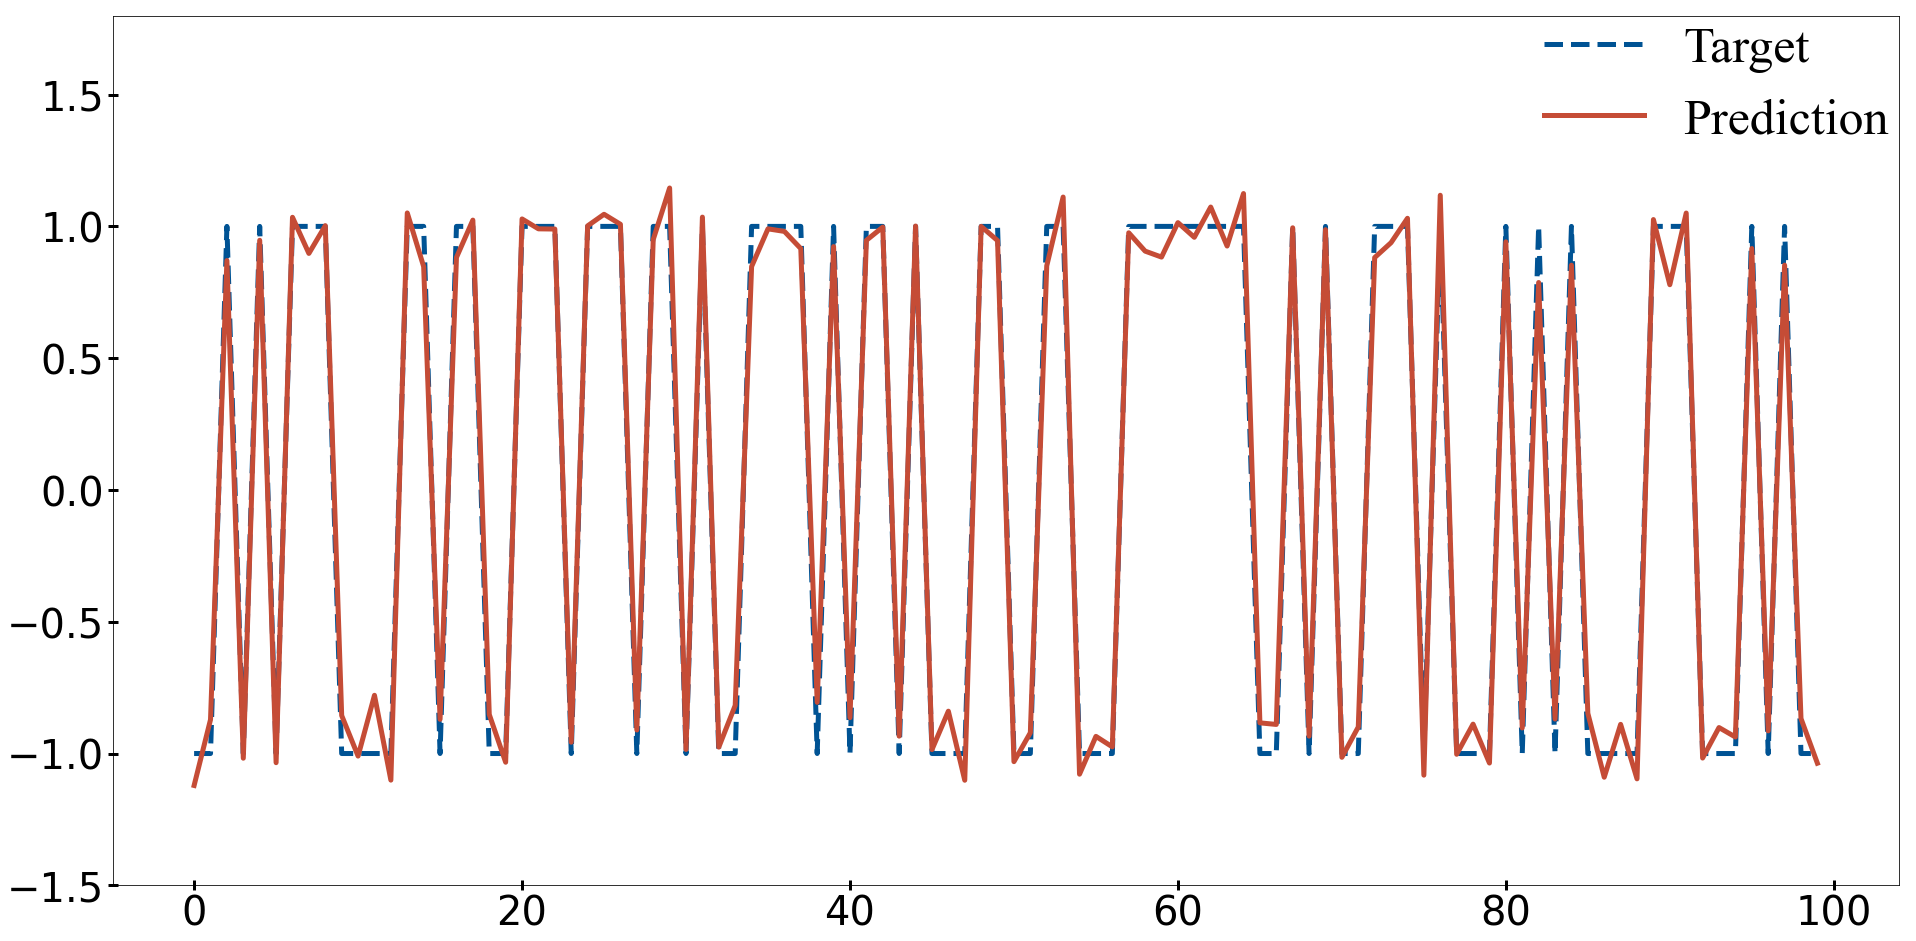

In [7]:
def learning(results, offset):
    y_true = mm.np.array(signal[2000-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    W = mm.np.linalg.inv(X.T @ X + 1e-17*mm.np.eye(X.shape[1])) @ X.T @ y_true
    return X @ W, y_true

def learning_gen(results, offset):
    y_true = mm.np.array(signal[2000-offset:2100-offset]) * 2 - 1
    y_test = mm.np.array(signal[2100-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    X_train = X[:100]
    X_test = X[100:]
    W = mm.np.linalg.inv(X_train.T @ X_train + 1e-17 *mm.np.eye(X_train.shape[1])) @ X_train.T @ y_true
    return X_test @ W, y_test

num_sig = mm.np.random.choice(num_signal_samples)
num_state = mm.np.random.choice(num_states_samples)
results = mm.np.load(path_EVAL + str(num_sig) + 'results' + str(num_state) + '.npy')
signal =  mm.np.load(path_EVAL + str(num_sig) + 'signal'  + '.npy')




# LEARNING EVALUATION

res, y_true = learning(results, 0)
fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
ax = plt.subplot(111)
ax.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax.set_ylim(-1.5, 1.7)
plt.plot(y_true, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res, label = 'Learning',linewidth=4, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.8,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)

fig.savefig(path_PRODUCT + 'LEARNING_p=0_rand_sig' + '.svg', format='svg', dpi=3000)


# GENERALIZATION

offset = 1
res_gen, y_true_gen = learning_gen(results, offset)

fig_gen = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=10)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 50,
        }
ax_gen = plt.subplot(111)
ax_gen.tick_params(axis='both', which='major', labelsize=40, width = 3, length = 10, direction = 'inout')
ax_gen.set_ylim(-1.5, 1.8)

plt.plot(y_true_gen, label = 'Target', linewidth=5, linestyle = '--', color = '#005394')
plt.plot(res_gen, label = 'Prediction',linewidth=5, color = '#C54C36')
leg = plt.legend(frameon=False, loc=(0.79,0.83), prop = font1)
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=5)


fig_gen.savefig(path_PRODUCT + 'PREDICTION_p=0_rand_sig' + '.svg', format='svg', dpi=3000)


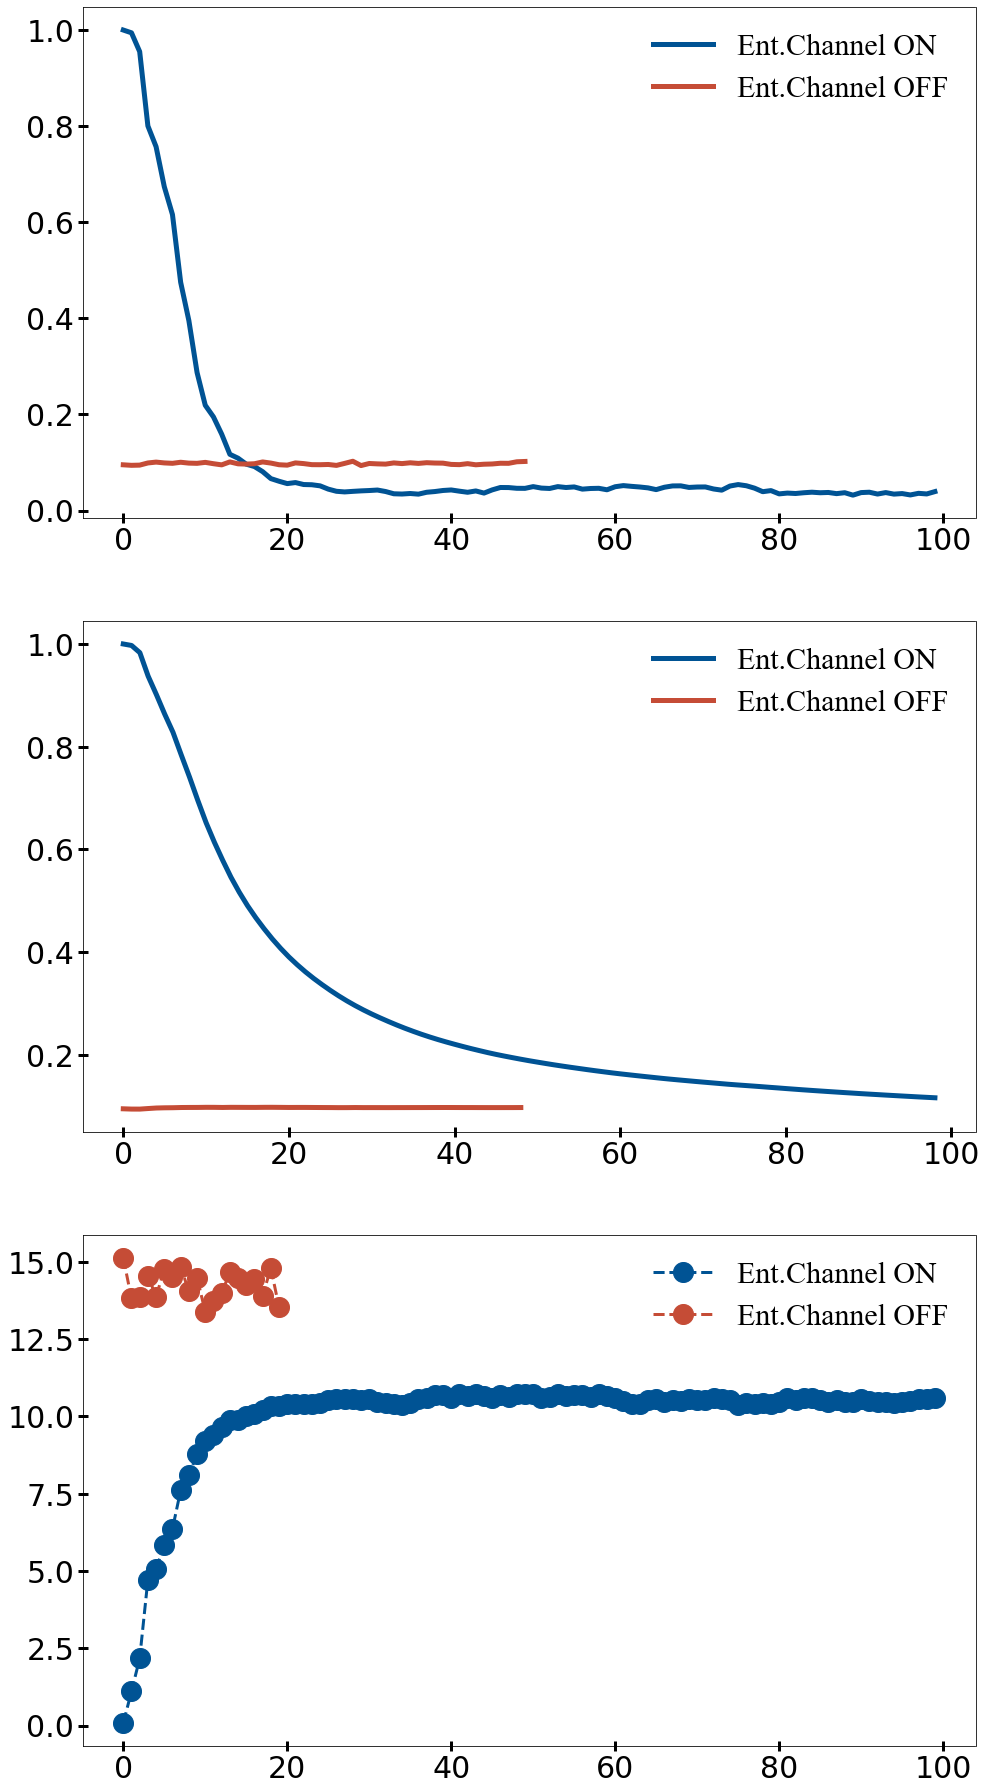

In [8]:

def learning(results, offset):
    y_true = mm.np.array(signal[2000-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    W = mm.np.linalg.inv(X.T @ X + 1e-17*mm.np.eye(X.shape[1])) @ X.T @ y_true
    return X @ W, y_true

def learning_gen(results, offset):
    y_true = mm.np.array(signal[2000-offset:2100-offset]) * 2 - 1
    y_test = mm.np.array(signal[2100-offset:2200-offset]) * 2 - 1
    X = results.reshape(-1, (mm.n_qubitsB) * multiplexing)
    X = mm.np.concatenate((X, mm.np.ones((X.shape[0], 1))), axis=1)
    X_train = X[:100]
    X_test = X[100:]
    W = mm.np.linalg.inv(X_train.T @ X_train + 1e-17 *mm.np.eye(X_train.shape[1])) @ X_train.T @ y_true
    return X_test @ W, y_test


def get_memory_acc(result):
    acc = []
    for i in range(100):
        res, y_true = learning(result, i)
        acc.append((mm.np.mean(res * y_true) - mm.np.mean(res) * mm.np.mean(y_true))**2/mm.np.var(res)/mm.np.var(y_true))
    return acc


def learn_acc(d_max, result):
    acc = []
    for d in range(d_max):
        res, y_true = learning_gen(result, d)
        acc.append(mm.np.linalg.norm(res - y_true))
        #acc.append(np.sum(res - y_true)**2)
        
    return mm.np.array(acc)

sig_av_macc = []
sig_av_mcap = []
sig_av_gen_loss = []

for s in range(num_signal_samples):
    signal =  mm.np.load(path_EVAL + str(s) + 'signal'  + '.npy')
    results = mm.np.load(path_EVAL + str(s) + 'results' + str(0) + '.npy')
    memory_acc = get_memory_acc(results)
    memory_cap = mm.np.array([mm.np.mean(memory_acc[0: d]) for d in range(1, len(memory_acc))])
    learning_acc = learn_acc(100,results)
    
    sig_av_macc.append(memory_acc)
    sig_av_mcap.append(memory_cap)
    sig_av_gen_loss.append(learning_acc)
    
#sig_av_macc = sum(sig_av_macc)/len(sig_av_macc)
#sig_av_mcap = sum(sig_av_mcap)/len(sig_av_mcap)
#sig_av_gen_loss = sum(sig_av_gen_loss)/len(sig_av_gen_loss)
    
sig_av_macc = mm.np.mean(mm.np.asarray(sig_av_macc), axis = 0)
sig_av_mcap  = mm.np.mean(mm.np.asarray(sig_av_mcap), axis = 0)
sig_av_gen_loss = mm.np.mean(mm.np.asarray(sig_av_gen_loss), axis = 0)

offb_sig_av_macc = mm.np.load(path_EVAL_AUX + 'sig_av_macc'+ '.npy')
offb_sig_av_mcap = mm.np.load(path_EVAL_AUX + 'sig_av_mcap'+ '.npy')
offb_sig_av_gen_loss = mm.np.load(path_EVAL_AUX + 'sig_av_gen_loss'+ '.npy')

fig3, ax3 = plt.subplots(3, figsize = (16,32))
#fig = plt.figure(figsize = (32, 16))
font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=25)
font1 = {'family': 'Times New Roman',
        'weight': 'normal',
        'size': 30,
        }

ax3[0].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[1].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')
ax3[2].tick_params(axis='both', which='major', labelsize=30, width = 3, length = 10, direction = 'inout')

ax3[0].plot(sig_av_macc, label = 'Ent.Channel ON', linewidth = 5, color = '#005394')
ax3[0].plot(offb_sig_av_macc, label = 'Ent.Channel OFF', linewidth = 5,  color = '#C54C36')
ax3[0].legend(loc = 'best', prop = font1, frameon = False)

ax3[1].plot(sig_av_mcap , label = 'Ent.Channel ON', linewidth = 5, color = '#005394')
ax3[1].plot(offb_sig_av_mcap, label = 'Ent.Channel OFF', linewidth = 5,  color = '#C54C36')
ax3[1].legend(loc = 'best',  prop = font1, frameon = False)

ax3[2].plot(sig_av_gen_loss, label = 'Ent.Channel ON', linewidth = 3, linestyle = '--',  marker = 'o',markersize = 20, color = '#005394')
ax3[2].plot(offb_sig_av_gen_loss[0:20], label = 'Ent.Channel OFF', linewidth = 3, linestyle = '--',  marker = 'o',markersize = 20, color = '#C54C36')
ax3[2].legend(loc = 'best',  prop = font1, frameon = False)

fig3.savefig(path_PRODUCT + 'TASKS_BENCHMARKS' + '.svg', format='svg', dpi=3000)